<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairClasification/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and clone repo

In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [2]:
!rm -rf ./HairClasification
!git clone https://github.com/CarmenTheodoraCraciun/HairClasification.git
!mv ./HairClasification/originalData/Straight/ ./HairClasification/originalData/straight
!mv ./HairClasification/originalData/Wavy/ ./HairClasification/originalData/wavy

Cloning into 'HairClasification'...
remote: Enumerating objects: 7606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7606 (delta 6), reused 5 (delta 5), pack-reused 7598 (from 1)
Receiving objects: 100% (7606/7606), 447.86 MiB | 27.79 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (4110/4110), done.


# Data processing


In [3]:
def is_image(file_path):
    try:
        img = cv2.imread(file_path)
        return img is not None
    except:
        return False

def resize_image(img, size):
    """
    Resizes an image using bilinear interpolation.

    Args:
        img: Input image.
        size: Desired size of the output image (width, height).

    Returns:
        Resized image.
    """
    original_height, original_width, _ = img.shape
    new_width, new_height = size
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_width):
        for j in range(new_height):
            #i, j = pixel in the resized image
            # x, y = pixel in the original image
            x = i * (original_width - 1) / (new_width - 1)
            y = j * (original_height - 1) / (new_height - 1)

            # Neighborhood values
            x0 = int(np.floor(x))
            x1 = min(x0 + 1, original_width - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, original_height - 1)

            # Extract the intensity values ​​of neighbors
            Ia = img[y0, x0] # stanga sus
            Ib = img[y0, x1] # drepata sus
            Ic = img[y1, x0] # stanga jos
            Id = img[y1, x1] # dreapta jos

            # Calculates the weight of each neighboring to the final value
            wa = (x1 - x) * (y1 - y)
            wb = (x - x0) * (y1 - y)
            wc = (x1 - x) * (y - y0)
            wd = (x - x0) * (y - y0)

            # The final value of the new pixel
            pixel = wa * Ia + wb * Ib + wc * Ic + wd * Id
            resized_img[j, i] = np.round(pixel).astype(int)

    return resized_img

def augment_image(img, size=(128, 128), shear_range=0.1, zoom_range=0.1, horizontal_flip=True):
    """
    Preprocesses and augments an image by applying resizing, shearing, zooming, and horizontal flipping.

    Args:
        img: Input image.
        size: Desired size of the output image (width, height).
        shear_range: Range for random shearing.
        zoom_range: Range for random zooming.
        horizontal_flip: Whether to randomly flip the image horizontally.

    Returns:
        Preprocessed and augmented image.
    """
    rows, cols, ch = img.shape
    shear_factor = np.random.uniform(-shear_range, shear_range)
    M_shear = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img, M_shear, (cols, rows))

    zoom_factor = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    img = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)

    if zoom_factor < 1: # zoom out
        new_height, new_width = img.shape[:2]
        # Number of pixels added to padding (black) and its addition
        pad_height = (rows - new_height) // 2
        pad_width = (cols - new_width) // 2
        img = cv2.copyMakeBorder(img, pad_height, pad_height,
            pad_width, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else: # zoom in
        # Position of the starting point for cutting
        start_x = (img.shape[1] - cols) // 2
        start_y = (img.shape[0] - rows) // 2
        img = img[start_y:start_y + rows, start_x:start_x + cols]

    if horizontal_flip and np.random.random() < 0.5:
        img = cv2.flip(img, 1)

    img = cv2.resize(img, size)

    return img

def preprocess_images(input_dir, output_dir, size=(128, 128), augment_prob=0.3):
    """
    Resizes images to the specified size and saves them to the output directory.
    Applies augmentations to a random subset of images.

    Args:
        input_dir: Directory containing the input images.
        output_dir: Directory to save the preprocessed images.
        size: Desired size of the output images (width, height).
        augment_prob: Probability of applying augmentation to each image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Start processing data.")
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        output_category_dir = os.path.join(output_dir, category)
        if not os.path.exists(output_category_dir):
            os.makedirs(output_category_dir)

        num_images = 0
        if os.path.isdir(category_dir):
            for idx, img_name in enumerate(os.listdir(category_dir)):
                img_path = os.path.join(category_dir, img_name)

                if is_image(img_path):
                    img = cv2.imread(img_path)
                    if img is not None:
                        if np.random.rand() < augment_prob:
                            img = augment_image(img, size=size)
                        else:
                            img = resize_image(img, size)
                        new_img_name = f"{category}_{idx}.png"
                        cv2.imwrite(os.path.join(output_category_dir, new_img_name), img)
                        num_images += 1
                    else:
                        print(f"Failed to load image: {img_path}")
                else:
                    print(f"Not an image: {img_path}")

        print(f"Folder {output_category_dir} has {num_images} images.")

    print("The data are processed.")

In [4]:
if not os.path.exists('./HairClasification/processData'):
  preprocess_images('./HairClasification/originalData', './HairClasification/processData', size=(128, 128), augment_prob=0.3)

In [ ]:
# import shutil

# shutil.make_archive('/content/HairClasification/processData', 'zip', '/content/HairClasification/processData')
# from google.colab import files

# files.download('/content/HairClasification/processData.zip')

##Loading data with labels

In [6]:
def load_images_and_labels(input_dir, size=(128, 128)):
    images = []
    labels = []
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)

In [7]:
input_dir = './HairClasification/processData'
images, labels = load_images_and_labels(input_dir)

##Data Augmentation and Normalization

* Normalization - to contain only 0 and 1 values

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to all images in the dataset
augmented_images = []
augmented_labels = []

for img, label in zip(images, labels):
    img = img.astype('float32') / 255.0  # Normalize the image
    img = img[np.newaxis, ...]  # Expand dimensions for datagen flow
    gen = datagen.flow(img, batch_size=1)
    # Generate a few augmented images per original image (e.g., 5 augmentations each)
    for _ in range(5):
        aug_img = next(gen)[0]  # Correct usage of next() function
        augmented_images.append(aug_img)
        augmented_labels.append(label)


images_augmented = np.array(augmented_images)
labels_augmented = np.array(augmented_labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    images_augmented,
    labels_augmented,
    test_size=0.2,
    random_state=42
)

##One-hot Encoding

* One-hot encoding is a technique used to convert categorical data into a numeric format that a machine learning model can understand
  * e.g. [0,0,0,1,0] means that the hair is straight.


In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [11]:
train_datagen = datagen.flow(X_train, y_train_categorical, batch_size=32)
validation_datagen = ImageDataGenerator().flow(X_test, y_test_categorical, batch_size=32)

#Building the model

## Loading into the VGG16 pre-trained model

VGG16 is a well-known and powerful convolutional neural network (CNN) model developed by the Visual Geometry Group (VGG) research team at the University of Oxford. Its name, VGG16, derives from its 16-layer deep neural network structure.

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##Building on top of VGG16

In [13]:
# Initialize the model as a sequential stack of layers
model = Sequential()

# Add the pre-trained base model
# This serves as a feature extractor to reuse learned features from another task
model.add(base_model)

# Add a convolutional layer with 64 filters and a 3x3 kernel, ReLU activation
# Padding is set to 'same' to preserve spatial dimensions
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Add a max pooling layer to downsample the feature maps
# This reduces spatial dimensions and captures the strongest signals in regions
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 128 filters and a 3x3 kernel, ReLU activation
# Padding is again set to 'same' to preserve dimensions
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Add another max pooling layer to further downsample feature maps
model.add(MaxPooling2D((2, 2)))

# Flatten the output feature maps into a 1D vector for the dense layers
model.add(Flatten())

# Add a dense (fully connected) layer with 256 neurons and ReLU activation
# Apply L2 regularization to discourage large weights and avoid overfitting
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Add a dropout layer to randomly deactivate 50% of neurons during training
# This helps prevent overfitting and improves generalization
model.add(Dropout(0.5))

# Add the output dense layer with a softmax activation function
# The number of neurons is equal to the number of classes (derived from label_encoder.classes_)
# This produces probabilities for each class in a multi-class classification task
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

#Compiling and training

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(train_datagen, epochs=10, validation_data=validation_datagen, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2021s 8s/step - accuracy: 0.4276 - loss: 2.3018 - val_accuracy: 0.6537 - val_loss: 1.0592
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1997s 8s/step - accuracy: 0.6476 - loss: 1.0659 - val_accuracy: 0.7215 - val_loss: 0.7804
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2000s 8s/step - accuracy: 0.6939 - loss: 0.8726 - val_accuracy: 0.7220 - val_loss: 0.7687
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1985s 8s/step - accuracy: 0.7271 - loss: 0.7950 - val_accuracy: 0.7590 - val_loss: 0.6523
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2008s 8s/step - accuracy: 0.7173 - loss: 0.7879 - val_accuracy: 0.7629 - val_loss: 0.6282
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1989s 8s/step - accuracy: 0.7424 - loss: 0.7364 - val_accuracy: 0.7815 - val_loss: 0.5810
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1979s 8s/step - accuracy: 0.7505 - loss: 0.6969 - val_accuracy: 0.7776 - val_loss: 0.5973
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2038s 8s/step - accuracy: 0.7669 - loss: 0.6633 - 

#Model evaluation

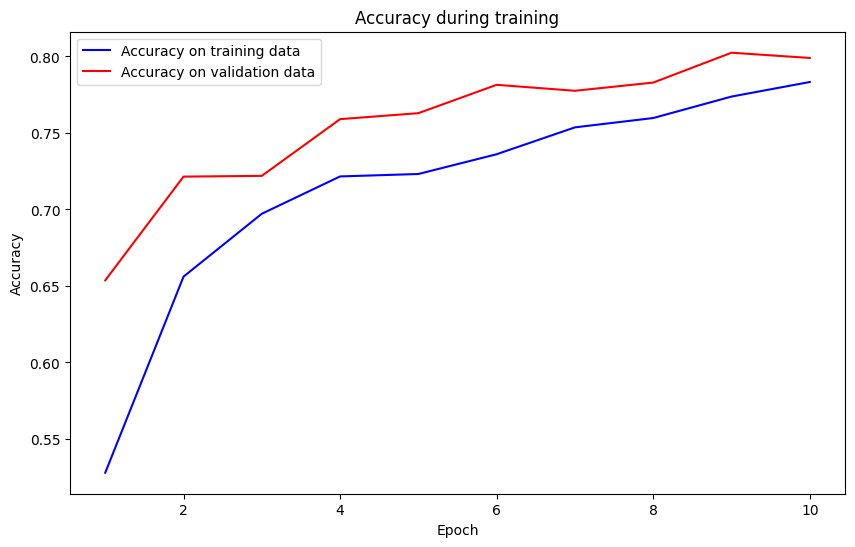

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b', label='Accuracy on training data')
plt.plot(epochs, val_accuracy, 'r', label='Accuracy on validation data')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {accuracy:.4f}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 425s 6s/step - accuracy: 0.7967 - loss: 0.5353
Test accuracy: 0.8024


In [20]:
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

65/65 ━━━━━━━━━━━━━━━━━━━━ 393s 6s/step
              precision    recall  f1-score   support

       curly       0.83      0.80      0.81       527
  dreadlocks       0.85      0.86      0.86       457
       kinky       0.70      0.84      0.77       246
    straight       0.80      0.84      0.82       498
        wavy       0.79      0.63      0.70       322

    accuracy                           0.80      2050
   macro avg       0.79      0.80      0.79      2050
weighted avg       0.80      0.80      0.80      2050



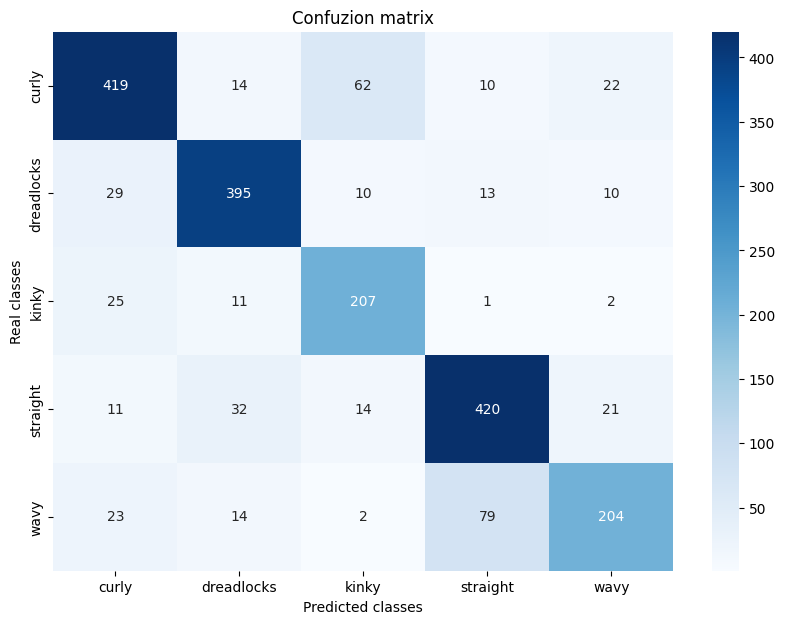

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confuzion matrix")
plt.ylabel("Real classes")
plt.xlabel("Predicted classes")
plt.show()